# Кросс валидация

Используется для того чтобы выбрать модель из некоторого множества вариантов
Есть несколько методов

**Тестирование на отложенной выборке** - Разбиваем данные на группы заранее. Как правило нужно применять если данных много и модель учится долго

**K-fold** - разбиваем на фолды, на одном тестим на остальных обучаемся и так K раз

**Leave One Out** - экстремальный K-Fold когда оставляем один объект на тест

### Подготовим данные

In [1]:
import numpy as np
import pandas as pd
from geo import *
import lightgbm
from sklearn import model_selection

/Users/tylorn/envs/dmia2019/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv("data/ny_taxi_fare_1m.csv").drop(['Unnamed: 0'], axis=1)

In [4]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,18.0,2015-02-23 15:59:15 UTC,-73.980843,40.747425,-74.004707,40.708378,1
1,18.9,2009-07-14 09:22:00 UTC,-73.979997,40.762613,-74.010148,40.703322,1
2,52.0,2015-04-09 20:03:00 UTC,-73.989105,40.746273,-73.990692,40.746906,1
3,11.5,2013-07-04 01:26:00 UTC,-74.006647,40.743880,-73.989765,40.720782,5
4,8.9,2010-08-06 19:15:39 UTC,-73.988505,40.748976,-73.974706,40.736039,1


In [5]:
df['pickup_datetime'] = df.pickup_datetime.astype("datetime64")

Признак длина поездки должно быть очень информативен

In [6]:
df['dist'] = earth_distance(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)

Время и дата тоже могут влиять

In [7]:
df['month'] = df.pickup_datetime.dt.month

In [8]:
df['hour'] = df.pickup_datetime.dt.hour

Самую малось почитим данные

In [9]:
df = df[(df.fare_amount != 0) & (df.dist > 500) & (df.dist < 100000)]

In [10]:
df.dist.plot(kind='hist')

In [11]:
def extract_data(extr_df):
    X = extr_df.drop(['fare_amount', 'pickup_datetime'], axis=1).values
    y = extr_df.fare_amount.values
    return X, y

In [12]:
X, y = extract_data(df)

Попробуем что-нибудь обучить 

## Тестирование на отложенной выборке

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=2019)

In [14]:
y_pred = np.ones_like(y_test) * np.median(y_train)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 41.37727646918887


In [15]:
regr = lightgbm.LGBMRegressor(objective='mape')

In [16]:
regr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective='mape',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [17]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 16.41881508655729


## K-fold

In [18]:
kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=2019)

In [19]:
y_pred = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = lightgbm.LGBMRegressor(objective='mape')
    regr.fit(X_train, y_train)
    y_pred.extend(regr.predict(X_test))
y_pred = np.array(y_pred)

In [20]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 18.416892476020035


## Есть сомнения?

In [21]:
def df_time_hist(time_s):
    return time_s.groupby([df["pickup_datetime"].dt.year, df["pickup_datetime"].dt.month]).count().plot(figsize=(20, 8), kind="bar")

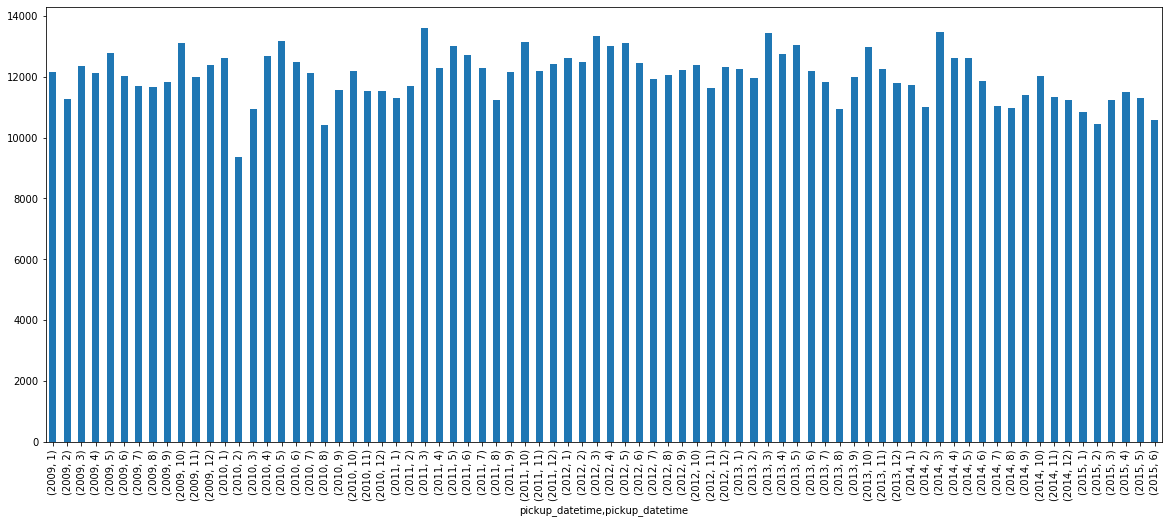

In [22]:
df_time_hist(df.pickup_datetime)

Посмотрим на среднюю цену за каждый год

In [23]:
df.groupby(df.pickup_datetime.dt.year)[['fare_amount']].mean()

,fare_amount
pickup_datetime,
2009,10.164359
2010,10.251178
2011,10.514173
2012,11.325546
2013,12.752329
2014,13.026675
2015,13.118228


Видим что цена растет. Это значит что качество полученное на валидации не честное, тк реальные данные будут отличаться от текущих.

## Разобьем выборку по времени

In [24]:
train_ind = df.pickup_datetime.dt.year < 2014
test_ind = ~train_ind

In [25]:
X_train, y_train = extract_data(df[train_ind])
X_test, y_test = extract_data(df[test_ind])

In [26]:
X_train.shape, X_test.shape

((731249, 8), (207242, 8))

In [27]:
regr = lightgbm.LGBMRegressor(objective='mape')
regr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective='mape',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 22.217394487430568


Качество ухудшилось. Хотя метод все тот же.

Но теперь мы больше ему доверяем.

**Если имеем дело с временными данными, безопаснее разбивать по времени, если нет оснований делать по другому.**